In [1]:
import polars as pl
from datetime import date,datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyarrow
import random

In [2]:
# read in all csv files with polars
city_features_df = pl.read_csv('./city_cgm_plus_features.csv')
dclp3_features_df = pl.read_csv('./dclp3_cgm_plus_features.csv')
dclp5_features_df = pl.read_csv('./dclp5_cgm_plus_features.csv')
flair_features_df = pl.read_csv('./flair_cgm_plus_features.csv')
hall18_features_df = pl.read_csv('./hall18_cgm_plus_features.csv')
mdex_features_df = pl.read_csv('./mdex_cgm_plus_features.csv')
ndiab_features_df = pl.read_csv('./ndiab_cgm_plus_features.csv')
repbg_features_df = pl.read_csv('./repbg_cgm_plus_features.csv')
rtcgm_features_df = pl.read_csv('./rtcgm_cgm_plus_features.csv')
sence_features_df = pl.read_csv('./sence_cgm_plus_features.csv')
sevhypo_features_df = pl.read_csv('./sevhypo_cgm_plus_features.csv')
wisdm_features_df = pl.read_csv('./wisdm_cgm_plus_features.csv')

city_demo_df = pl.read_csv('./city_demographic_data.csv')
dclp3_demo_df = pl.read_csv('./dclp3_demographic_data.csv')
dclp5_demo_df = pl.read_csv('./dclp5_demographic_data.csv')
flair_demo_df = pl.read_csv('./flair_demographic_data.csv')
hall18_demo_df = pl.read_csv('./hall18_demographic_data.csv')
mdex_demo_df = pl.read_csv('./mdex_demographic_data.csv')
repbg_demo_df = pl.read_csv('./repbg_demographic_data.csv')
rtcgm_demo_df = pl.read_csv('./rtcgm_demographic_data.csv')
sence_demo_df = pl.read_csv('./sence_demographic_data.csv')
sevhypo_demo_df = pl.read_csv('./sevhypo_demographic_data.csv')
wisdm_demo_df = pl.read_csv('./wisdm_demographic_data.csv')

In [3]:
city_df = city_features_df.join(city_demo_df, on="SID", how="left")
dclp3_df = dclp3_features_df.join(dclp3_demo_df, on="SID",how="left")
dclp5_df = dclp5_features_df.join(dclp5_demo_df, on="SID",how="left")
flair_df = flair_features_df.join(flair_demo_df, on="SID",how="left")
hall18_df = hall18_features_df.join(hall18_demo_df, on="SID", how="left")
mdex_df = mdex_features_df.join(mdex_demo_df, on="SID", how="left")
repbg_df = repbg_features_df.join(repbg_demo_df, on="SID", how="left")
rtcgm_df = rtcgm_features_df.join(rtcgm_demo_df, on="SID", how="left")
sence_df = sence_features_df.join(sence_demo_df, on="SID", how="left")
sevhypo_df = sevhypo_features_df.join(sevhypo_demo_df, on="SID", how="left")
wisdm_df = wisdm_features_df.join(wisdm_demo_df, on="SID", how="left")

In [4]:
hall18_df = hall18_df.with_columns(pl.col("Age").cast(pl.Int64))
sevhypo_df = sevhypo_df.with_columns(pl.col("Age").fill_null(-1).cast(pl.Int64))

In [5]:
# create a list of the dataframes excluding city and dclp3 dataframe to vstack
df_list = [dclp5_df ,flair_df ,hall18_df ,mdex_df ,repbg_df ,rtcgm_df ,sence_df ,sevhypo_df ,wisdm_df]

# vstack city and dclp3 dataframe
combined_df = city_df.vstack(dclp3_df)

# iterate through and add the remaining 10 datasets to the combined df
for i in df_list:
    combined_df = combined_df.vstack(i)

In [6]:
# create the date and date_time columns
combined_df = combined_df.with_columns(combined_df['Date'].str.replace(r'\.0+', '').alias('Date'))
combined_df = combined_df.with_columns(pl.col('Date').str.to_datetime('%Y-%m-%d %H:%M:%S').alias('Date'))
combined_df = combined_df.with_columns(combined_df['Date_Time'].str.replace(r'\.[0-9]+', '').alias('Date_Time'))
combined_df = combined_df.with_columns(pl.col('Date_Time').str.to_datetime('%Y-%m-%d %H:%M:%S').alias('Date_Time'))

In [7]:
# Select Data for EDA Analysis
EDA_data = combined_df.select('SID','Day','Hour','Min'
                              ,'DT_Index','DailyTI_Index'
                              ,'StudyTI_Index','BMI','BMI_Class'
                              ,'Tx_Modality', 'Race', 'Sex','Age'
                              , 'Value')
#EDA_data.write_csv('./CGM_EDA_data.csv')

In [8]:
EDA_data

SID,Day,Hour,Min,DT_Index,DailyTI_Index,StudyTI_Index,BMI,BMI_Class,Tx_Modality,Race,Sex,Age,Value
str,i64,i64,i64,str,i64,i64,f64,str,str,str,str,i64,f64
"""CITY-1""",0,18,19,"""2000-03-25 18:…",219,219,23.187635,"""Normalweight""","""MDI""","""White""","""F""",18,278.0
"""CITY-1""",0,18,24,"""2000-03-25 18:…",220,220,23.187635,"""Normalweight""","""MDI""","""White""","""F""",18,273.0
"""CITY-1""",0,18,29,"""2000-03-25 18:…",221,221,23.187635,"""Normalweight""","""MDI""","""White""","""F""",18,258.0
"""CITY-1""",0,18,34,"""2000-03-25 18:…",222,222,23.187635,"""Normalweight""","""MDI""","""White""","""F""",18,251.0
"""CITY-1""",0,18,39,"""2000-03-25 18:…",223,223,23.187635,"""Normalweight""","""MDI""","""White""","""F""",18,247.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""WISDM-99""",391,9,38,"""2001-05-07 09:…",115,112723,35.257869,"""Obese""","""MDI""","""White""","""F""",62,269.0
"""WISDM-99""",391,9,43,"""2001-05-07 09:…",116,112724,35.257869,"""Obese""","""MDI""","""White""","""F""",62,273.0
"""WISDM-99""",391,9,48,"""2001-05-07 09:…",117,112725,35.257869,"""Obese""","""MDI""","""White""","""F""",62,269.0


In [9]:
# get the unique number of patients
len(combined_df['SID'].unique())

1826

In [10]:
# group by patient id and day and get the count of readings per day
daily_id_counts = combined_df.group_by(['SID', 'Day']).agg(pl.col('DT_Index').count().alias('DT_Index_Count'))

In [11]:
# sort by paitent ID and day
daily_id_counts = daily_id_counts.sort(['SID', 'Day'])

In [12]:
# Filter to the number of patient days with 288 readings (reading every 5 minutes)
complete_days = daily_id_counts.filter(pl.col('DT_Index_Count') >= 288)

# Print number of days
len(complete_days)

101168

In [13]:
# create the SID_Day key to join to data to filter out records not a part of complete days
complete_days = complete_days.with_columns(
    pl.concat_str(
        [
            pl.col("SID"),
            pl.col("Day"),
        ],
        separator=" ",
    ).alias("SID_Day"),
)

In [14]:
# number of complete days of readings each patient has
complete_days.group_by(['SID']).agg(pl.col('Day').count().alias('Complete_Days'))

SID,Complete_Days
str,u32
"""CITY-86""",77
"""SENCE-128""",56
"""SEVHYPO-82""",2
"""CITY-99""",184
"""SENCE-99""",183
…,…
"""SENCE-157""",40
"""DCLP3-003-020""",133
"""FLAIR-23""",78


In [15]:
# create the SID_Day key to join to data to filter out records not a part of complete days
combined_df = combined_df.with_columns(
    pl.concat_str(
        [
            pl.col("SID"),
            pl.col("Day"),
        ],
        separator=" ",
    ).alias("SID_Day"),
)

In [16]:
# inner join the complete days with all records to create dataset we will use for model building and eval
records_kept = combined_df.join(complete_days, on = 'SID_Day', how = 'inner')
records_kept.head(1)

SID,Date_Time,Date,Day,Hour,Min,DT_Index,DailyTI_Index,StudyTI_Index,Value,Study,Age,Sex,Race,BMI,BMI_Class,Baseline_HbA1c,Tx_Modality,Diabetes_Type,SID_Day,SID_right,Day_right,DT_Index_Count
str,datetime[μs],datetime[μs],i64,i64,i64,str,i64,i64,f64,str,i64,str,str,f64,str,f64,str,str,str,str,i64,u32
"""CITY-1""",2000-03-26 00:04:54,2000-03-26 00:00:00,1,0,4,"""2000-03-26 00:…",0,288,234.0,"""CITY""",18,"""F""","""White""",23.187635,"""Normalweight""",8.2,"""MDI""","""T1D""","""CITY-1 1""","""CITY-1""",1,288


In [17]:
# check that the number of complete days is the same as the number of unique days in records kept
len(complete_days)==len(records_kept["SID_Day"].unique())

True

In [18]:
len(records_kept["SID_Day"].unique())

101168

In [19]:
# Export data for modeling
export_data = records_kept.select('SID','Day','Hour','Min','DT_Index','DailyTI_Index','StudyTI_Index','BMI','BMI_Class','Tx_Modality','Value')
#export_data.write_csv('./CGM_model_data.csv')

In [20]:
export_data.group_by(['SID', 'Day']).agg(pl.col('DT_Index').count().alias('DT_Index_Count')).filter(pl.col('DT_Index_Count') >= 288)

SID,Day,DT_Index_Count
str,i64,u32
"""CITY-1""",234,288
"""CITY-1""",252,288
"""CITY-1""",258,288
"""CITY-1""",301,288
"""CITY-1""",324,288
…,…,…
"""WISDM-98""",153,288
"""WISDM-98""",154,288
"""WISDM-98""",164,288


In [21]:
complete_data_all = export_data.to_pandas()

### Profiling Missingness

In [22]:
# sort dataframe by SID and Date_Time
combined_df = combined_df.sort(['SID', 'Date_Time'])

# create a previous missing readings column
df = combined_df.with_columns(
    pl.when(combined_df['SID'] == combined_df['SID'].shift(1))
        .then(combined_df['StudyTI_Index'] - combined_df['StudyTI_Index'].shift(1)-1)
        .otherwise(None).alias('previous_missing_readings')
)

# make any missing more than 1000 readings be 1000
df = df.with_columns(
    pl.when(df['previous_missing_readings'] >1000)
        .then(1000)
        .otherwise(df['previous_missing_readings']).alias('previous_missing_readings')
)

In [23]:
# Number of days missing 1 or 2 readings
len(df.filter((pl.col('previous_missing_readings')==1) | (pl.col('previous_missing_readings')==2)))

3004598

Text(0.5, 1.0, 'Histogram of previous_missing_readings')

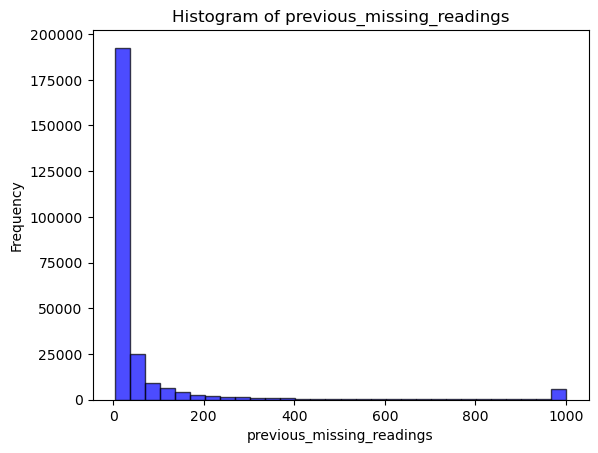

In [24]:
# Missing readings are defined as more than 3 missing readings for the project
missing_readings = df.filter(pl.col('previous_missing_readings') > 3)

# create data for a histogram by converting to Numpy
hist_data = missing_readings['previous_missing_readings'].to_numpy()

# Plot a histogram using matplotlib
plt.hist(hist_data, bins=30, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('previous_missing_readings')
plt.ylabel('Frequency')
plt.title('Histogram of previous_missing_readings')

In [25]:
# Calculate the percentage of readings missing each count
pct_missing_reads = missing_readings.group_by('previous_missing_readings').agg(pl.col('previous_missing_readings').count().alias('Count')).select(
        pl.col('previous_missing_readings'),
        (pl.col('Count') / len(missing_readings)).alias('Percent')*100
    )

In [26]:
# Look at the readings missing less than 8 hours of data
missing_pct_interest = pct_missing_reads.filter(pl.col('previous_missing_readings') <= 96).sort('previous_missing_readings')

In [27]:
# Calculate the percentage each group is missing from 4 to 96 to Generate distribution for test set
missing_pct_interest = missing_pct_interest.select(pl.col('previous_missing_readings'),
                                                   (pl.col('Percent') / missing_pct_interest['Percent'].sum()).alias('Frequency')
    )

In [28]:
missing_distribution = missing_pct_interest.to_pandas()

In [29]:
# Ensure sums to 100
missing_pct_interest['Frequency'].sum()

1.0000000000000007

In [30]:
# View table
missing_pct_interest.write_csv('./test_weights.csv')

### Introduce Missingness

In [31]:
np.random.seed(26)

In [32]:
unique_combinations = complete_data_all[['SID', 'Day']].drop_duplicates()
unique_combinations = unique_combinations.sample(frac=1, random_state=26).reset_index(drop=True)

total_combinations = len(unique_combinations)
train_end = int(total_combinations * 0.7)
test_end = train_end + int(total_combinations * 0.2)

train_combinations = unique_combinations[:train_end].reset_index(drop = True).copy()
test_combinations = unique_combinations[train_end:test_end].reset_index(drop = True).copy()
val_combinations = unique_combinations[test_end:].reset_index(drop = True).copy()


In [33]:
train_data = pd.merge(complete_data_all, train_combinations, how = 'inner', on = ['SID','Day'])
test_data = pd.merge(complete_data_all, test_combinations, how = 'inner', on = ['SID','Day'])
val_data = pd.merge(complete_data_all, val_combinations, how = 'inner', on = ['SID','Day'])

In [34]:
missing_distribution.columns = ['missing_counts','frequency']

In [35]:
missing_distribution['missing_counts'] = missing_distribution['missing_counts'].apply(
    lambda x: 24 if 13 <= x <= 24 else (48 if 25 <= x <= 48 else (96 if 49 <= x <= 96 else x)))

In [36]:
missing_distribution = missing_distribution.groupby('missing_counts').sum().reset_index()

In [37]:
num_missing_assignments = np.random.choice(missing_distribution['missing_counts'].to_list(), size=len(test_combinations), p=missing_distribution['frequency'].to_list())

In [38]:
random.seed(26)

In [39]:
start_missing = [random.randint(5, 287 - num_missing) for num_missing in num_missing_assignments]

In [40]:
test_combinations['num_missing'] = num_missing_assignments
test_combinations['start_missing'] = start_missing

In [41]:
SID = []
Day = []
missing_reading = []

for i in range(len(test_combinations)):
    for n in range(test_combinations['num_missing'][i]):
        SID.append(test_combinations['SID'][i])
        Day.append(test_combinations['Day'][i])
        missing_reading.append(test_combinations['start_missing'][i] + n)
        

In [42]:
test_missing = pd.DataFrame({'SID': SID,'Day':Day, 'DailyTI_Index':missing_reading, 'filter':missing_reading})

In [43]:
test_set = pd.merge(test_data, test_missing, how = 'left', on = ['SID','Day','DailyTI_Index'])
test_set = test_set[test_set['filter'].isna()].reset_index(drop = True).copy()

##### Val Set

In [44]:
random.seed(27)
np.random.seed(27)

In [45]:
num_missing_assignments = np.random.choice(missing_distribution['missing_counts'].to_list(), size=len(val_combinations), p=missing_distribution['frequency'].to_list())

In [46]:
start_missing = [random.randint(5, 287 - num_missing) for num_missing in num_missing_assignments]

In [47]:
val_combinations['num_missing'] = num_missing_assignments
val_combinations['start_missing'] = start_missing

In [48]:
SID = []
Day = []
missing_reading = []

for i in range(len(val_combinations)):
    for n in range(val_combinations['num_missing'][i]):
        SID.append(val_combinations['SID'][i])
        Day.append(val_combinations['Day'][i])
        missing_reading.append(val_combinations['start_missing'][i] + n)
        

In [49]:
val_missing = pd.DataFrame({'SID': SID,'Day':Day, 'DailyTI_Index':missing_reading, 'filter':missing_reading})

In [50]:
val_set = pd.merge(val_data, val_missing, how = 'left', on = ['SID','Day','DailyTI_Index'])
val_set = val_set[val_set['filter'].isna()].reset_index(drop = True).copy()

In [51]:
val_set.to_csv('./Glucose_Validation_Set.csv', header = True, index=False)
test_set.to_csv('./Glucose_Test_Set.csv', header = True, index=False)
train_data.to_csv('./Glucose_Train_Set.csv', header = True, index=False)

val_data.to_csv('./Glucose_Validation_Set_Complete.csv', header = True, index=False)
test_data.to_csv('./Glucose_Test_Set_Complete.csv', header = True, index=False)

### Check test/val set worked

In [52]:
test_set = pl.from_pandas(test_set)

In [53]:
# sort dataframe by SID and Date_Time
test_set = test_set.sort(['SID', 'StudyTI_Index'])

# create a previous missing readings column
df = test_set.with_columns(
    pl.when(test_set['SID'] == test_set['SID'].shift(1))
        .then(test_set['StudyTI_Index'] - test_set['StudyTI_Index'].shift(1)-1)
        .otherwise(None).alias('previous_missing_readings')
)

# make any missing more than 1000 readings be 1000
df = df.with_columns(
    pl.when(df['previous_missing_readings'] >1000)
        .then(1000)
        .otherwise(df['previous_missing_readings']).alias('previous_missing_readings')
)

In [54]:
df = df.to_pandas()

In [55]:
df[df['previous_missing_readings'].isna()]

,SID,Day,Hour,Min,DT_Index,DailyTI_Index,StudyTI_Index,BMI,BMI_Class,Tx_Modality,Value,filter,previous_missing_readings
0,CITY-1,1,0,4,2000-03-26 00:00:00,0,288,23.187635,Normalweight,MDI,234.0,NaN,NaN
3984,CITY-10,181,0,0,2000-07-25 00:00:00,0,52128,22.427711,Normalweight,PUMP,375.0,NaN,NaN
6058,CITY-101,190,0,0,2000-09-29 00:00:00,0,54720,25.234509,Overweight,PUMP,181.0,NaN,NaN
9092,CITY-102,213,0,4,2000-10-21 00:00:00,0,61344,24.334776,Normalweight,PUMP,224.0,NaN,NaN
12008,CITY-103,117,0,1,2000-10-31 00:00:00,0,33696,24.689795,Normalweight,MDI,60.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5284184,WISDM-93,2,0,3,2000-03-16 00:00:00,0,576,27.464767,Overweight,PUMP,89.0,NaN,NaN
5286288,WISDM-94,206,0,0,2001-01-12 00:00:00,0,59328,22.294722,Normalweight,MDI,262.0,NaN,NaN
5289263,WISDM-95,8,0,3,2000-03-13 00:00:00,0,2304,24.836323,Normalweight,PUMP,160.0,NaN,NaN
5290870,WISDM-97,13,0,1,2000-02-17 00:00:00,0,3744,23.670933,Normalweight,PUMP,86.0,NaN,NaN


In [56]:
df['SID'].drop_duplicates()

0            CITY-1
3984        CITY-10
6058       CITY-101
9092       CITY-102
12008      CITY-103
             ...   
5284184    WISDM-93
5286288    WISDM-94
5289263    WISDM-95
5290870    WISDM-97
5299045    WISDM-98
Name: SID, Length: 1291, dtype: object

In [57]:
test_check = df[(df['previous_missing_readings']> 0) & (df['previous_missing_readings']< 287)][['SID','Day', 'DailyTI_Index', 'previous_missing_readings']]

In [58]:
test_combinations

,SID,Day,num_missing,start_missing
0,WISDM-120,271,6,108
1,DCLP3-004-017,91,11,110
2,CITY-114,265,48,115
3,DCLP3-003-001,55,48,158
4,SENCE-143,237,48,144
...,...,...,...,...
20228,DCLP3-004-012,120,4,146
20229,REPBG-244,77,48,222
20230,RTCGM-103,321,24,121
20231,WISDM-97,298,6,152


In [59]:
test_check

,SID,Day,DailyTI_Index,previous_missing_readings
42,CITY-1,1,90,48.0
279,CITY-1,3,135,96.0
703,CITY-1,5,283,12.0
806,CITY-1,12,104,6.0
1220,CITY-1,24,234,4.0
...,...,...,...,...
5304086,WISDM-98,167,261,96.0
5304245,WISDM-98,168,180,48.0
5304449,WISDM-98,173,101,5.0
5304914,WISDM-98,188,284,6.0


In [60]:
checking = pd.merge(test_combinations, test_check, how = 'left', on = ['SID','Day'])

In [61]:
checking[checking['previous_missing_readings'].isna()]

,SID,Day,num_missing,start_missing,DailyTI_Index,previous_missing_readings


#### Review Distribution of Artifical Missingness

Text(0.5, 1.0, 'Histogram of Test Missing Start Point')

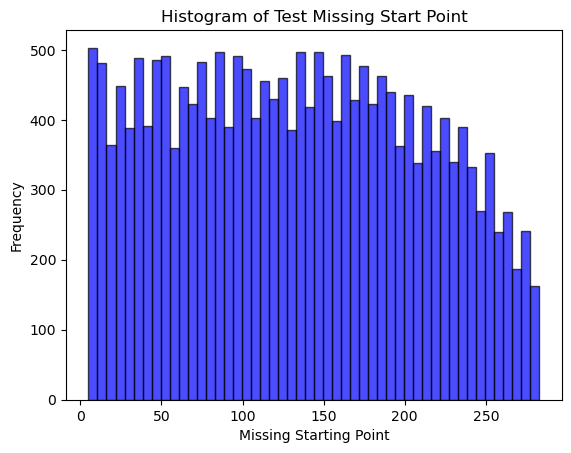

In [62]:
# create data for a histogram by converting to Numpy
hist_data = test_combinations['start_missing'].to_numpy()

# Plot a histogram using matplotlib
plt.hist(hist_data, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Missing Starting Point')
plt.ylabel('Frequency')
plt.title('Histogram of Test Missing Start Point')

Text(0.5, 1.0, 'Histogram of Val Missing Start Point')

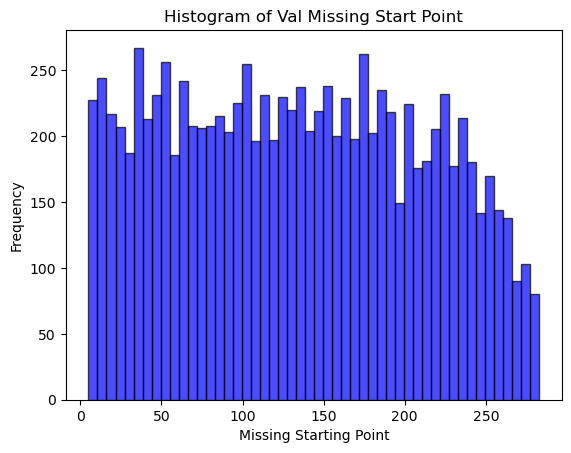

In [63]:
# create data for a histogram by converting to Numpy
hist_data = val_combinations['start_missing'].to_numpy()

# Plot a histogram using matplotlib
plt.hist(hist_data, bins=50, alpha=0.7, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Missing Starting Point')
plt.ylabel('Frequency')
plt.title('Histogram of Val Missing Start Point')

In [64]:
test_missing_dist = pd.DataFrame(test_combinations.groupby('num_missing').count()['SID']/sum(test_combinations.groupby('num_missing').count()['SID'])).reset_index()
val_missing_dist = pd.DataFrame(val_combinations.groupby('num_missing').count()['SID']/sum(val_combinations.groupby('num_missing').count()['SID'])).reset_index()

In [65]:
test_check = pd.merge(missing_distribution, test_missing_dist, right_on = 'num_missing', left_on='missing_counts')[['missing_counts','frequency','SID']]
test_check.columns = ['missing_counts','true_freq','artificial_freq']
test_check['diff'] = abs(test_check['true_freq'] - test_check['artificial_freq'])
test_check.sort_values('diff', ascending=False)

,missing_counts,true_freq,artificial_freq,diff
11,96,0.090205,0.093263,0.003059
6,10,0.027062,0.028864,0.001802
3,7,0.052190,0.050610,0.001580
9,24,0.170595,0.169228,0.001366
5,9,0.034401,0.033411,0.000990
8,12,0.020843,0.020017,0.000826
7,11,0.026440,0.027183,0.000744
1,5,0.112861,0.112193,0.000669
10,48,0.195674,0.195077,0.000597
0,4,0.158211,0.158701,0.000491


In [66]:
val_check = pd.merge(missing_distribution, val_missing_dist, right_on = 'num_missing', left_on='missing_counts')[['missing_counts','frequency','SID']]
val_check.columns = ['missing_counts','true_freq','artificial_freq']
val_check['diff'] = abs(val_check['true_freq'] - val_check['artificial_freq'])
val_check.sort_values('diff', ascending=False)

,missing_counts,true_freq,artificial_freq,diff
1,5,0.112861,0.118008,0.005146
3,7,0.052190,0.048132,0.004058
2,6,0.074780,0.071259,0.003521
4,8,0.036739,0.039534,0.002795
10,48,0.195674,0.193022,0.002652
7,11,0.026440,0.028563,0.002123
11,96,0.090205,0.091915,0.001711
6,10,0.027062,0.025598,0.001464
9,24,0.170595,0.169401,0.001194
8,12,0.020843,0.021941,0.001098
